In [18]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# CSV 資料
df = load_csv_to_df("hsinchu.csv")
# 簡單檢查

print(df.head())


  鄉鎮市區 交易標的    土地位置建物門牌  土地移轉總面積平方公尺      都市土地使用分區 非都市土地使用分區 非都市土地使用編定  \
0  新竹市   土地  中寮段490-2地號        42.78    都市：其他:道路用地       NaN       NaN   
1  新竹市   土地  聚吉段83-12地號        38.00  都市：其他:第二種住宅區       NaN       NaN   
2  新竹市   土地  朝山段369-2地號        31.84           NaN       NaN       NaN   
3  新竹市   土地    古峰段688地號       124.46    都市：其他:道路用地       NaN       NaN   
4  新竹市   土地  福林段378-1地號       173.77    都市：其他:道路用地       NaN       NaN   

     交易年月日      交易筆棟數 移轉層次  ... 車位類別 車位移轉總面積平方公尺 車位總價元  \
0  1140505  土地1建物0車位0  NaN  ...  NaN         0.0     0   
1  1140503  土地3建物0車位0  NaN  ...  NaN         0.0     0   
2  1140502  土地1建物0車位0  NaN  ...  NaN         0.0     0   
3  1140506  土地1建物0車位0  NaN  ...  NaN         0.0     0   
4  1140506  土地1建物0車位0  NaN  ...  NaN         0.0     0   

                          備註                   編號  主建物面積  附屬建物面積  陽台面積  電梯  \
0               包含公共設施保留地用地；  RPWOMLKMMHKGFAO66DA    0.0     0.0   0.0   無   
1  土增稅、履保費、代書費等均由買方支付。未登記建物；  RPWOMLQJNHKGFAO07DA 

In [9]:
import pandas as pd

# 假設你的 DataFrame 名叫 df，欄位名稱是 'column_name'
distinct_values = df['移轉層次'].unique()
print(distinct_values)


[nan '二十一層' '七層' '十一層' '九層' '十五層' '一層' '十二層' '二層' '地下二層' '三層' '全' '五層'
 '四層' '十六層' '六層' '十四層' '十三層' '八層' '二十三層' '十層' '地下四層' '二十層' '一層，二層，夾層'
 '一層，見其他登記事項' '二層，三層' '一層，騎樓' '地下一層' '十七層' '一層，地下層' '地下三層' '十九層' '七層，夾層'
 '十層，見其他登記事項' '二十二層' '二十四層' '十一層，十二層' '一層，地下一層' '十八層' '三層，四層，五層'
 '一層，二層，三層' '一層，二層，三層，騎樓' '二十六層' '六層，七層' '五層，見其他登記事項']


In [3]:
# 用正則表達式從文字中擷取數字
df['land'] = df['交易筆棟數'].str.extract(r'土地(\d+)').astype(int)
df['building'] = df['交易筆棟數'].str.extract(r'建物(\d+)').astype(int)
df['parking'] = df['交易筆棟數'].str.extract(r'車位(\d+)').astype(int)

In [4]:
df["trading_amount"]= df['land']+df['building']+df['parking']

In [ ]:
mapping = {
    '車位': 1,
    '建物': 2,
    '土地': 3,
    '房地(土地+建物)': 4,
    '房地(土地+建物)+車位': 4
}

df['交易標的'] = df['交易標的'].map(mapping)

In [6]:
df['土地位置建物門牌'] = df['土地位置建物門牌'].str.replace(
    r'^[\u4e00-\u9fa5]{2,3}市[\u4e00-\u9fa5]{1,3}區', '', regex=True
)

df['土地位置建物門牌'] = df['土地位置建物門牌'].str.replace(
    r'^[\u4e00-\u9fa5]{2,3}市[\u4e00-\u9fa5]{1,3}市', '', regex=True
)


In [7]:
import pandas as pd
import numpy as np
import re

# 假設 df["總樓層數"] 內容如下
# df["總樓層數"] = ['二十二層', '七層', '十二層', np.nan, '三十層', '一層']

# 中文數字對照表
chinese_to_num = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5,
    '六': 6, '七': 7, '八': 8, '九': 9, '十': 10
}

def chinese_floor_to_num(text):
    if pd.isna(text):
        return 0  # NaN 填 0
    
    text = re.sub('層', '', str(text))  # 移除「層」字
    
    # 處理「十」字在中間或開頭的情況
    if text == '十':
        return 10
    elif text.startswith('十'):  # 十三 -> 13
        return 10 + chinese_to_num.get(text[1], 0)
    elif text.endswith('十'):  # 三十 -> 30
        return chinese_to_num.get(text[0], 0) * 10
    elif '十' in text:  # 二十三 -> 23
        parts = text.split('十')
        return chinese_to_num.get(parts[0], 0) * 10 + chinese_to_num.get(parts[1], 0)
    else:  # 一層 -> 1
        return chinese_to_num.get(text, 0)

# 套用轉換
df['總樓層數'] = df['總樓層數'].apply(chinese_floor_to_num)



In [ ]:
### ===== 分析一：總價元（百萬元） ===== ###
df['總價元'] = pd.to_numeric(df['總價元'], errors='coerce')
df_total = df.dropna(subset=['總價元'])
df_total = df_total[df_total['總價元'] > 0]

total_prices = df_total['總價元'] / 1e6
df["total_prices"] = df_total['總價元'] / 1e6
mean_total = total_prices.mean()
median_total = total_prices.median()
min_total = total_prices.min()
max_total = total_prices.max()
midpoint_total = (min_total + max_total) / 2

print(f"\n🔸 總價元統計（百萬元）")
print(f"L2 最佳代表值（平均數）: {mean_total:.2f}")
print(f"L1 最佳代表值（中位數）: {median_total:.2f}")
print(f"L∞ 最佳代表值（中點）: {midpoint_total:.2f}")


🔸 總價元統計（百萬元）
L2 最佳代表值（平均數）: 17.98
L1 最佳代表值（中位數）: 12.00
L∞ 最佳代表值（中點）: 847.67


In [ ]:
# ===== 簡單的單變數回歸（坪數 → 總價） ===== #
from sklearn.linear_model import LinearRegression

df["total_prices"] = df_total['總價元'] / 1e6
X = df["trading_amount"]
y = df["total_prices"]

model1 = LinearRegression()
model1.fit(X, y)

print("\n單變數模型（交易棟數 → 總價）:")
print(f"截距 w0 = {model1.intercept_:.2f}")
print(f"斜率 w1 = {model1.coef_[0]:.2f} (每增加一個交易件數增加多少百萬)")

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [16]:
# ===== 簡單的單變數回歸（交易棟數 → 總價） ===== #
from sklearn.linear_model import LinearRegression

# 建立目標變數（以百萬元為單位）
df["total_prices"] = df_total["總價元"] / 1e5

# 自變數與應變數
X = df[["trading_amount"]]   # ✅ 雙層中括號確保是 DataFrame（2D）
y = df["total_prices"]

# 建立並訓練模型
model1 = LinearRegression()
model1.fit(X, y)

# 印出結果
print("\n單變數模型（交易棟數 → 總價）:")
print(f"截距 w0 = {model1.intercept_:.2f}")
print(f"斜率 w1 = {model1.coef_[0]:.2f}（每增加一個交易件數，總價平均增加多少百萬）")



單變數模型（交易棟數 → 總價）:
截距 w0 = 133.63
斜率 w1 = 14.85（每增加一個交易件數，總價平均增加多少百萬）


/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/andyw.p.chen/Documents/Project/2025_Fraud-Detection-project/virtual/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767

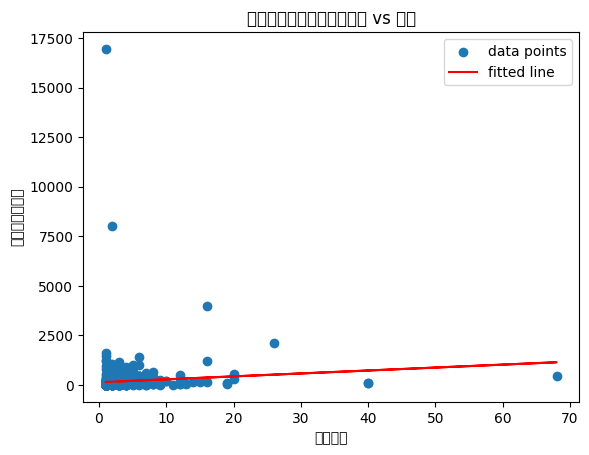

In [17]:
import matplotlib.pyplot as plt

plt.scatter(X, y, label="data points")
plt.plot(X, model1.predict(X), color="red", label="fitted line")
plt.xlabel("交易棟數")
plt.ylabel("總價（百萬元）")
plt.title("單變數線性回歸：交易棟數 vs 總價")
plt.legend()
plt.show()
